In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [15]:
processed_dir = Path("../data/processed")
in_path = processed_dir / "windows_identity_df.csv"

df = pd.read_csv(in_path)
print("Loaded dataset:", df.shape)
df.head()

Loaded dataset: (78914, 18)


,max,mean,std,range,energy,label,subject_id,age_group,activity_code,age,height_cm,weight_kg,gender,pid,synthetic_name,synthetic_address,synthetic_phone,synthetic_patient_id
0,1.505301,1.021371,0.161249,0.748475,213.839935,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
1,1.686817,1.094025,0.183646,0.891159,246.123306,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
2,1.598864,1.042618,0.176089,0.814388,223.612030,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
3,1.388703,1.040773,0.144043,0.621426,220.791382,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
4,1.441374,1.059405,0.145564,0.639070,228.705505,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177


In [16]:
FEATURE_COLS = ["max", "mean", "std", "range", "energy"]

LABEL_COL = "label"
GROUP_COL = "subject_id"

X = df[FEATURE_COLS]
y = df["label"]
groups = df["subject_id"]  # split por sujeito

EPSILONS = [2.0, 1.0, 0.5]

print("X:", X.shape)
print("y distribution:", y.value_counts().to_dict())
print("Subjects:", groups.nunique())


X: (78914, 5)
y distribution: {0: 52066, 1: 26848}
Subjects: 38


In [17]:
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train subjects:", groups.iloc[train_idx].nunique())
print("Test subjects:", groups.iloc[test_idx].nunique())

Train size: (65242, 5)
Test size: (13672, 5)
Train subjects: 30
Test subjects: 8


In [18]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [19]:
t0 = time.perf_counter()
logreg_pipeline.fit(X_train, y_train)
train_time_lr = time.perf_counter() - t0

In [20]:
t0 = time.perf_counter()
y_pred_lr = logreg_pipeline.predict(X_test)
test_time_lr = time.perf_counter() - t0

In [21]:
print("=== Logistic Regression ===")
print("Train time (s):", round(train_time_lr, 4))
print("Test time (s):", round(test_time_lr, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=["ADL","Fall"]))
cm_lg = confusion_matrix(y_test, y_pred_lr)


=== Logistic Regression ===
Train time (s): 0.0655
Test time (s): 0.0017
Balanced accuracy: 0.6143249774178946
              precision    recall  f1-score   support

         ADL       0.87      0.43      0.57     10313
        Fall       0.31      0.80      0.45      3359

    accuracy                           0.52     13672
   macro avg       0.59      0.61      0.51     13672
weighted avg       0.73      0.52      0.54     13672



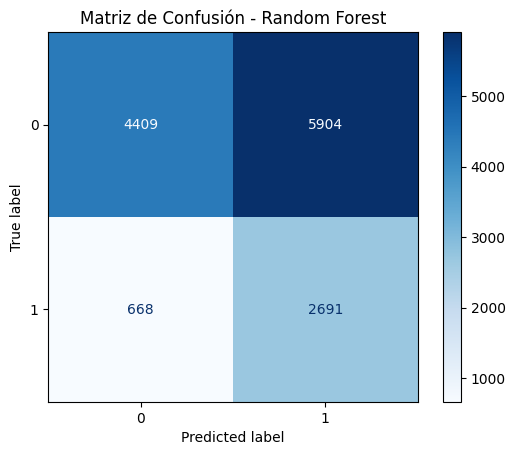

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [23]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

In [24]:
t0 = time.perf_counter()
rf.fit(X_train, y_train)
train_time_rf = time.perf_counter() - t0

In [25]:
t0 = time.perf_counter()
y_pred_rf = rf.predict(X_test)
test_time_rf = time.perf_counter() - t0

In [26]:
print("=== Random Forest ===")
print("Train time (s):", round(train_time_rf, 4))
print("Test time (s):", round(test_time_rf, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=["ADL","Fall"]))
cm_rf = confusion_matrix(y_test, y_pred_rf)

=== Random Forest ===
Train time (s): 4.9878
Test time (s): 0.0604
Balanced accuracy: 0.6242163451575107
              precision    recall  f1-score   support

         ADL       0.82      0.82      0.82     10313
        Fall       0.43      0.43      0.43      3359

    accuracy                           0.72     13672
   macro avg       0.62      0.62      0.62     13672
weighted avg       0.72      0.72      0.72     13672



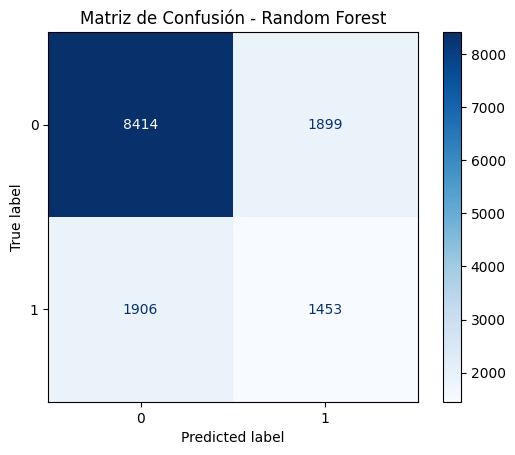

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [28]:
summary = pd.DataFrame([
    {
        "model": "Logistic Regression",
        "train_time_s": train_time_lr,
        "test_time_s": test_time_lr,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_lr),
    },
    {
        "model": "Random Forest",
        "train_time_s": train_time_rf,
        "test_time_s": test_time_rf,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_rf),
    }
])

summary


,model,train_time_s,test_time_s,balanced_accuracy
0,Logistic Regression,0.065454,0.001691,0.614325
1,Random Forest,4.987848,0.060382,0.624216


In [29]:
def eval_models(X_train, y_train, X_test, y_test):
    models = {
        "LogReg": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    }

    rows = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        rows.append({
            "model": name,
            "balanced_accuracy": balanced_accuracy_score(y_test, pred),
            "f1_macro": f1_score(y_test, pred, average="macro")
        })
    return pd.DataFrame(rows)

In [30]:
res_all = []

res_b = eval_models(
    df[FEATURE_COLS].iloc[train_idx], df[LABEL_COL].iloc[train_idx],
    df[FEATURE_COLS].iloc[test_idx],  df[LABEL_COL].iloc[test_idx]
)
res_b["setting"] = "baseline"
res_all.append(res_b)


In [31]:
for eps in EPSILONS:
    df_before = pd.read_csv(processed_dir / f"windows_df_dp_before_eps{eps}.csv")
    df_after  = pd.read_csv(processed_dir / f"windows_identity_dp_after_eps{eps}.csv")

    # DP BEFORE
    res_before = eval_models(
        df_before[FEATURE_COLS].iloc[train_idx], df_before[LABEL_COL].iloc[train_idx],
        df_before[FEATURE_COLS].iloc[test_idx],  df_before[LABEL_COL].iloc[test_idx]
    )
    res_before["setting"] = f"dp_before_eps={eps}"
    res_all.append(res_before)

    # DP AFTER
    res_after = eval_models(
        df_after[FEATURE_COLS].iloc[train_idx], df_after[LABEL_COL].iloc[train_idx],
        df_after[FEATURE_COLS].iloc[test_idx],  df_after[LABEL_COL].iloc[test_idx]
    )
    res_after["setting"] = f"dp_after_eps={eps}"
    res_all.append(res_after)

results = pd.concat(res_all, ignore_index=True)
results


,model,balanced_accuracy,f1_macro,setting
0,LogReg,0.523898,0.484726,baseline
1,RandomForest,0.626174,0.625010,baseline
2,LogReg,0.500000,0.429977,dp_before_eps=2.0
3,RandomForest,0.499424,0.485034,dp_before_eps=2.0
4,LogReg,0.500000,0.429977,dp_after_eps=2.0
5,RandomForest,0.501080,0.474732,dp_after_eps=2.0
6,LogReg,0.500000,0.429977,dp_before_eps=1.0
7,RandomForest,0.502032,0.487085,dp_before_eps=1.0
8,LogReg,0.500000,0.429977,dp_after_eps=1.0
9,RandomForest,0.499985,0.467686,dp_after_eps=1.0


In [32]:
pivot_acc = results.pivot(index="model", columns="setting", values="balanced_accuracy")
pivot_acc

setting,baseline,dp_after_eps=0.5,dp_after_eps=1.0,dp_after_eps=2.0,dp_before_eps=0.5,dp_before_eps=1.0,dp_before_eps=2.0
model,,,,,,,
LogReg,0.523898,0.500000,0.500000,0.50000,0.500000,0.500000,0.500000
RandomForest,0.626174,0.502315,0.499985,0.50108,0.503102,0.502032,0.499424


In [41]:
def load_before(eps):
    return pd.read_csv(processed_dir / f"windows_df_dp_before_eps{eps}.csv")

def load_after(eps):
    return pd.read_csv(processed_dir / f"windows_identity_dp_after_eps{eps}.csv")

In [37]:
classes = sorted(df[LABEL_COL].unique())
classes

[np.int64(0), np.int64(1)]

In [38]:
models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    )
}


In [39]:
def full_model_report(model, X_train, y_train, X_test, y_test, labels_order):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rep = classification_report(
        y_test, y_pred,
        labels=labels_order,
        output_dict=True,
        zero_division=0
    )

    cm = confusion_matrix(y_test, y_pred, labels=labels_order)

    summary = {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }

    return rep, cm, summary


In [42]:
all_reports = []          # vai guardar summaries
all_class_reports = []    # vai guardar o report por classe em tabela
all_conf_mats = {}        # (setting, model) -> cm

def run_setting(df, setting_name):
    X_train = df[FEATURE_COLS].iloc[train_idx]
    y_train = df[LABEL_COL].iloc[train_idx]
    X_test  = df[FEATURE_COLS].iloc[test_idx]
    y_test  = df[LABEL_COL].iloc[test_idx]

    for model_name, model in models.items():
        rep, cm, summary = full_model_report(model, X_train, y_train, X_test, y_test, classes)

        # summary
        all_reports.append({
            "setting": setting_name,
            "model": model_name,
            **summary
        })

        # guardar confusion matrix
        all_conf_mats[(setting_name, model_name)] = cm

        # classification report (por classe) -> tabela
        rep_df = pd.DataFrame(rep).T
        rep_df["setting"] = setting_name
        rep_df["model"] = model_name
        rep_df["row"] = rep_df.index
        all_class_reports.append(rep_df.reset_index(drop=True))

        # print bonito
        print("\n" + "="*90)
        print(f"SETTING: {setting_name} | MODEL: {model_name}")
        print("-"*90)
        print("Summary:", summary)
        print("\nClassification report:")
        print(pd.DataFrame(rep).T)
        print("\nConfusion matrix (rows=true, cols=pred) | labels:", classes)
        print(cm)

# Baseline
run_setting(df, "baseline")

# DP before e DP after
for eps in EPSILONS:
    df_b = load_before(eps)
    df_a = load_after(eps)

    run_setting(df_b, f"dp_before_eps={eps}")
    run_setting(df_a, f"dp_after_eps={eps}")



SETTING: baseline | MODEL: LogReg
------------------------------------------------------------------------------------------
Summary: {'accuracy': 0.7603861907548274, 'balanced_accuracy': 0.5238975702084736, 'f1_macro': 0.48472589441318936, 'f1_weighted': 0.6764200644891644}

Classification report:
              precision    recall  f1-score       support
0              0.763380  0.988849  0.861609  10313.000000
1              0.632588  0.058946  0.107843   3359.000000
accuracy       0.760386  0.760386  0.760386      0.760386
macro avg      0.697984  0.523898  0.484726  13672.000000
weighted avg   0.731247  0.760386  0.676420  13672.000000

Confusion matrix (rows=true, cols=pred) | labels: [np.int64(0), np.int64(1)]
[[10198   115]
 [ 3161   198]]

SETTING: baseline | MODEL: RandomForest
------------------------------------------------------------------------------------------
Summary: {'accuracy': 0.7194997074312464, 'balanced_accuracy': 0.626174495365613, 'f1_macro': 0.62501026745885

In [43]:
summary_df = pd.DataFrame(all_reports)
summary_df.sort_values(["model", "setting"])


,setting,model,accuracy,balanced_accuracy,f1_macro,f1_weighted
0,baseline,LogReg,0.760386,0.523898,0.484726,0.676420
12,dp_after_eps=0.5,LogReg,0.754315,0.500000,0.429977,0.648677
8,dp_after_eps=1.0,LogReg,0.754315,0.500000,0.429977,0.648677
4,dp_after_eps=2.0,LogReg,0.754315,0.500000,0.429977,0.648677
10,dp_before_eps=0.5,LogReg,0.754315,0.500000,0.429977,0.648677
6,dp_before_eps=1.0,LogReg,0.754315,0.500000,0.429977,0.648677
2,dp_before_eps=2.0,LogReg,0.754315,0.500000,0.429977,0.648677
1,baseline,RandomForest,0.719500,0.626174,0.625010,0.720753
13,dp_after_eps=0.5,RandomForest,0.726009,0.502315,0.469599,0.657173
9,dp_after_eps=1.0,RandomForest,0.722645,0.499985,0.467686,0.655065


In [44]:
class_report_df = pd.concat(all_class_reports, ignore_index=True)
class_report_df.head()


,precision,recall,f1-score,support,setting,model,row
0,0.763380,0.988849,0.861609,10313.000000,baseline,LogReg,0
1,0.632588,0.058946,0.107843,3359.000000,baseline,LogReg,1
2,0.760386,0.760386,0.760386,0.760386,baseline,LogReg,accuracy
3,0.697984,0.523898,0.484726,13672.000000,baseline,LogReg,macro avg
4,0.731247,0.760386,0.676420,13672.000000,baseline,LogReg,weighted avg
